## Setup project

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

%matplotlib inline

## Analitycal solution - from Francesco Romaggi whitepaper

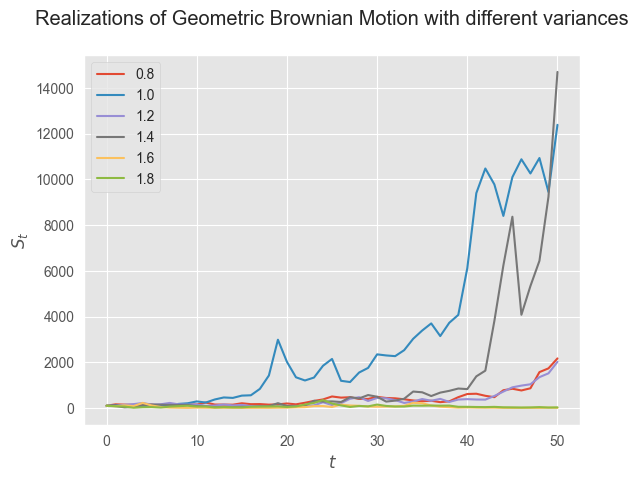

In [12]:
"""
Created on Mon Apr 28 12:45:23 2025

@author: Francesco Romaggi
"""

"""
Notice by playing on the variables mu and sigma the user can generate
different
Geometric Brownian Motions
"""



# 1. PARAMETERS OF THE MODEL
mu = 1 #mean
n = 50 #number of samples
dt = 0.1 #discretization chosen
x0 = 100 #scaling factor
np.random.seed(1) #seed chosen for the random sampling
sigma = np.arange(0.8, 2, 0.2) #array of the sigma values


# 2. MODEL and SIMULATION
x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T #Wiener part
)
x = np.vstack([np.ones(len(sigma)), x]) #vertical array of ones
x = x0 * x.cumprod(axis=0) #cumulative product for the columns scaled by x0

# 3. PLOTTING
plt.plot(x)
plt.legend(np.round(sigma, 2)) #rounding up to 2 decimals in the legend
plt.xlabel("$t$")
plt.ylabel("$S_t$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n"
)
plt.show()


## Numerical solution - from Francesco Romaggi Paper

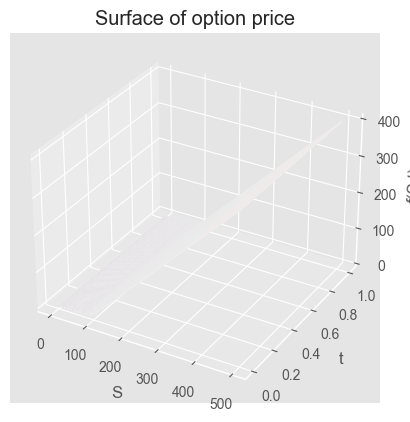

In [13]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 28 12:42:49 2025

@author: Francesco Romaggi
"""

"""
Notice that in numpy np.log stands for the natural logarithm

Notice that sections 1. and 2. of this script are the ones where the user
can
interact in order to decline the Black-Scholes equation in the different
scenarios analyzed

Notice the variable: chosen_method is the one that allows the user to
choose
the Backward or Forward Finite Difference Method implementation
"""


#choose which Finite Difference Method you want to iplement ('implicit' or
#'explicit')
chosen_method = 'implicit' #otherwise: 'explicit'


# 1. PARAMETERS OF THE MODEL
#choose different parameters based on your needs
r = 0.05 #risk free interest rate
sigma = 0.2 #volatility
K = 100.0 #strike price
S_max = 5 * K #maximum price of the security (we chose aribtrary 5 times K)
T = 1.0 #expiration time (one unit of the chosen time scale)

# 1.1. parameters related to the change of variables
k = 2*r/(sigma**2)
α = (1-k)/2
β = (-(k+1)**2)/4


# 2. DISCRETIZATION
N = 200 #number of [x] steps
M = 2000 #number of [τ] steps


# 3. GRID TIME-SPACE
#space
x_min = np.log(1e-6) #arbitrary chosen AND ALSO due to how the change of
#variables is defined
x_max = np.log(S_max/K) #due to how the change of variables is defined
x = np.linspace(x_min, x_max, N + 1) # #{N+1} points array [x_min; ...; x_max]
dx = x[1] - x[0]
#time
τ_max = (sigma**2)*T/2 #due to how the change of variables is defined
dτ = τ_max / M #due to how the change of variables is defined
τ = np.linspace(0, τ_max, M + 1) # #{M+1} points array [0; ...; τ_max]
#array of the values of the security
S_grid = K * np.exp(x) #due to how the change of variables is defined


# 4. INITIALIZATION OF THE GRID OF VALUES
U = np.zeros((M+1, N+1)) #matrix (M+1)x(N+1) of zeros


# 6. BOUNDARIES
#x-->-\infty
U[:,0] = 0
#x-->+\infty
#U[:,-1] = np.exp((1-α)*x_max - β*τ) <-- this would have been the approximated
#version
#from τ we obtain t_market
t_market = T - (2 * τ / sigma**2)
U[:, -1] = (S_max - K * np.exp(-r * (T - t_market))) / (K * np.exp(α*x_max + β*τ))

#t=0
U[0,:] = np.maximum(np.exp(((k+1)/2)*x) - np.exp(((k-1)/2)*x), 0)


# 7.a IMPLICIT SCHEME
if chosen_method == "implicit":
    # tridiagonal matrix
    delta = dτ / dx**2
    sub = -delta * np.ones(N - 2)
    main = (1 + 2 * delta) * np.ones(N - 1)
    sup = -delta * np.ones(N - 2)
    #construct the tridiagonal matrix based on the diagonals defined above
    A = np.diag(sub, -1) + np.diag(main) + np.diag(sup, 1)

    #implicit scheme implementation
    for j in range(1,M+1):
        #rhs i.e.: right hand side
        rhs = U[j-1, 1:-1].copy() #we take row by row at each iteration
        #excluding the boundaries (we leave the first and
        #last columns)

        #the following two rows correspond to the contributes of the boundaries
        rhs[0] += delta * U[j,0] #boundary at: x --> -\infty
        rhs[-1] += delta * U[j,-1] #bounadry at: and x --> +\infty

        #update the solution of the linear system in the matrix, and we'll use
        #it for the next iteration
        U[j, 1:-1] = np.linalg.solve(A, rhs) #we solve row by row each unknown variable

# 7.b EXPLICIT SCHEME
if chosen_method == "explicit":
    #definition of the delta
    delta = dτ / dx**2
    assert delta <= 0.5, f"Stability violated (δ={delta:.3f}>0.5) increase M or decrease dx"
    for i in range(M):
        #we exclude the first and last column
        U[i+1,1:-1] = (
                delta * U[i,0:-2] #take the whole row excluding the last two elements
                + (1-2*delta) * U[i,1:-1] #take the row excluding the first and last elements
                + delta * U[i,2:] #take the whole row starting from the third element
        )


# 8. TRASFORM BACK TO THE BLACK-SCHOLES MODEL
#trasformation based on the change of variables
V = np.zeros_like(U)
for i in range(M+1):
    V[i,:] = K * np.exp(α*x + β*τ[i]) * U[i,:] #due to how the change of variables is defined


# 9. PLOTTING SURFACE 3D
S_mesh, T_mesh = np.meshgrid(S_grid, t_market) #two matrixes composed by the input
#arrays repeated
fig = plt.figure() #create the figure object
ax = fig.add_subplot(111, projection='3d') #adding the 3D subplot to the fig object
ax.plot_surface(
    S_mesh, #x axes
    T_mesh, #y axes
    V, #z axes
    rstride=5, #skip 5 rows for drawing (less heavy to draw)
    cstride=5, #skip 5 columns for drawing (less heavy to draw)
    cmap='viridis', #heatmap based on the 'viridis scale'
    alpha=0.9 #opacity
)
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('f(S,t)')
ax.set_title('Surface of option price')
plt.show()


## Tridiagonal Matrix Algorithm - Thomas Algorithm

In [ ]:
def thomas(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    A: tridiagonal matrix
    b: right-hand side vector
    """

    x = np.diag(A, -1)
    y = np.diag(A)
    z = np.diag(A, 1)

    # A is the tridiagnonal coefficient matrix and d is the RHS matrix
    N = len(y)
    cp = np.zeros(N-1)
    dp = np.zeros(N)
    X = np.zeros(N)

    # Forward sweep
    cp[0] = z[0] / y[0]
    dp[0] = b[0] / y[0]

    for i in range(1, N-1):
        dnum = y[i] - x[i-1] * cp[i-1]
        cp[i] = z[i] / dnum
        dp[i] = (b[i] - x[i-1] * dp[i-1]) / dnum

    dp[N-1] = (b[N-1] - x[N-2] * dp[N-2]) / (y[N-1] - x[N-2] * cp[N-2])

    X[N-1] = dp[N-1]
    for i in np.arange(N-2, -1, -1):
        X[i] = dp[i] - cp[i] * X[i+1]

    return X

## Finitie Difference Methods

In [33]:
# EXPLICIT
def forward_time_centered_space(
        dt: float,
        dx: float,
        M: int,
        N: int,
        use_thomas: bool = True) -> np.ndarray:

    # initialization of the grid of values
    U = np.zeros((M+1, N+1)) #matrix (M+1)x(N+1) of zeros

    # boundaries
    # x --> 0
    U[:,0] = 0
    t_market = T - (2 * t / sigma**2)
    # x --> infinity
    U[:, -1] = (S_max - K * np.exp(-r * (T - t_market))) / (K * np.exp(a*x_max + b*t))

    #t=0
    U[0,:] = np.maximum(np.exp(((k+1)/2)*x) - np.exp(((k-1)/2)*x), 0)

    # tridiagonal matrix
    delta = dt / dx**2
    sub = -delta * np.ones(N - 2)
    main = (1 + 2 * delta) * np.ones(N - 1)
    sup = -delta * np.ones(N - 2)
    #construct the tridiagonal matrix based on the diagonals defined above
    A = np.diag(sub, -1) + np.diag(main) + np.diag(sup, 1)

    #implicit scheme implementation
    for j in range(1,M+1):
        #rhs i.e.: right hand side
        rhs = U[j-1, 1:-1].copy() #we take row by row at each iteration
        #excluding the boundaries (we leave the first and last columns)

        #the following two rows correspond to the contributes of the boundaries
        rhs[0] += delta * U[j,0] #boundary at: x --> -\infty
        rhs[-1] += delta * U[j,-1] #bounadry at: and x --> +\infty

        #update the solution of the linear system in the matrix, and we'll use
        #it for the next iteration

        if use_thomas:
            U[j, 1:-1]  = thomas(A, rhs)
        else:
            U[j, 1:-1] = np.linalg.solve(A, rhs)

    return U

# IMPLICIT
def backward_time_centered_space(
        dt: float,
        dx: float,
        M: int) -> np.ndarray:

    # initialization of the grid of values
    U = np.zeros((M+1, N+1)) #matrix (M+1)x(N+1) of zeros

    # boundaries
    # x --> 0
    U[:,0] = 0
    t_market = T - (2 * t / sigma**2)
    # x --> infinity
    U[:, -1] = (S_max - K * np.exp(-r * (T - t_market))) / (K * np.exp(a*x_max + b*t))

    #t=0
    U[0,:] = np.maximum(np.exp(((k+1)/2)*x) - np.exp(((k-1)/2)*x), 0)

    #definition of the delta
    delta = dt / dx**2
    assert delta <= 0.5, f"Stability violated (δ={delta:.3f}>0.5) increase M or decrease dx"
    for i in range(M):
        #we exclude the first and last column
        U[i+1,1:-1] = (
                delta * U[i,0:-2] #take the whole row excluding the last two elements
                + (1-2*delta) * U[i,1:-1] #take the row excluding the first and last elements
                + delta * U[i,2:] #take the whole row starting from the third element
        )

    return U

# CRANK-NICOLSON
def crank_nicolson(
        dt: float,
        rate: float,
        volatility: float,
        N: int,
        use_thomas = True) -> np.ndarray:

    # initialization of the grid of values
    U = np.zeros((M+1, N+1)) #matrix (M+1)x(N+1) of zeros


    # boundaries
    # x --> 0
    U[:,0] = 0
    t_market = T - (2 * t / sigma**2)
    # x --> infinity
    U[:, -1] = (S_max - K * np.exp(-r * (T - t_market))) / (K * np.exp(a*x_max + b*t))

    #t=0
    U[0,:] = np.maximum(np.exp(((k+1)/2)*x) - np.exp(((k-1)/2)*x), 0)
    I = np.arange(0, N+1)
    A = 0.25 * dt * ((volatility**2) * (I**2) - rate * I)
    B = -dt * 0.5 * (volatility**2 * (I**2) + rate)
    C = 0.25 * dt * (volatility**2 * (I**2) + rate * I)

    ML = sparse.diags([-A[2:], 1-B[1:], -C[1:]], [-1,0,1], shape=(N-1, N-1)).toarray()
    MR = sparse.diags([A[2:], 1+B[1:], C[1:]], [-1,0,1],shape=(N-1, N-1)).toarray()

    for j in range(1, M + 1):
        boundary_t = np.zeros(N - 1)
        # Left boundary contribution (index 0 in the reduced system corresponds to x[1])
        boundary_t[0] = A[1] * (U[j, 0] + U[j-1, 0]) - A[0]*U[j-1, 0]
        # Right boundary contribution (index N-2 in reduced system corresponds to x[N-1])
        boundary_t[-1] = C[N-1] * (U[j, N] + U[j-1, N])
        res = MR.dot(U[j-1, 1:N]) + boundary_t

        if use_thomas:
            U[j, 1:-1] = thomas(ML, res)
        else:
            U[j, 1:-1] = np.linalg.solve(ML, res)

    return U


## Create Plot

In [36]:
def plot_surface_3d(U):
    V = np.zeros_like(U)
    for i in range(M+1):
        V[i,:] = K * np.exp(a*x + b*t[i]) * U[i,:] #due to how the change of variables is defined


    # 9. PLOTTING SURFACE 3D
    S_mesh, T_mesh = np.meshgrid(S_grid, t_market) #two matrixes composed by the input
    #arrays repeated
    fig = plt.figure() #create the figure object
    ax = fig.add_subplot(111, projection='3d') #adding the 3D subplot to the fig object
    surf = ax.plot_surface(
        S_mesh, #x axes
        T_mesh, #y axes
        V, #z axes
        rstride=5, #skip 5 rows for drawing (less heavy to draw)
        cstride=5, #skip 5 columns for drawing (less heavy to draw)
        cmap='viridis', #heatmap based on the 'viridis scale'
        alpha=0.9 #opacity
    )
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.view_init(elev=45, azim=135)
    ax.set_xlabel('S')
    ax.set_ylabel('t')
    ax.set_zlabel('f(S,t)')
    ax.set_title('Surface of option price')
    plt.savefig('surface_of_option_price_normal.png')
    plt.show()

## Black Scholes Model

In [ ]:
# 1. PARAMETERS OF THE MODEL
#choose different parameters based on your needs
r = 0.05 #risk free interest rate
sigma = 0.2 #volatility
K = 100.0 #strike price
S_max = 5 * K #maximum price of the security (we chose aribtrary 5 times K)
T = 1.0 #expiration time (one unit of the chosen time scale)

# 1.1. parameters related to the change of variables
k = 2*r/(sigma**2)
a = (1-k)/2
b = (-(k+1)**2)/4


# 2. DISCRETIZATION
N = 200 #number of [x] steps
M = 2000 #number of [t] steps


# 3. GRID TIME-SPACE

#space
x_min = np.log(1e-6) #arbitrary chosen AND ALSO due to how the change of variables is defined
x_max = np.log(S_max/K) #due to how the change of variables is defined
x = np.linspace(x_min, x_max, N + 1) #{N+1} points array [x_min; ...; x_max]
dx = x[1] - x[0]

#time
t_max = (sigma**2)*T/2 #due to how the change of variables is defined
dt = t_max / M #due to how the change of variables is defined
t = np.linspace(0, t_max, M + 1) # #{M+1} points array [0; ...; t_max]

#array of the values of the security
S_grid = K * np.exp(x) #due to how the change of variables is defined

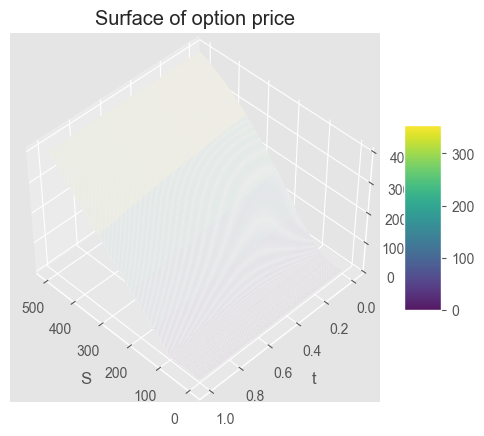

In [40]:
plot_surface_3d(crank_nicolson(dt, r, sigma, N, use_thomas = True))

## Performance